### In this notebook a predictive model is created where a sentiment analysis is performed based on social media posts given a dataset with the appropriate positive or negative rating, this in order for an organization to take action on the impact of a product on its customers by posting on social networks and analyze those ratings. This is done using natural language processing (NLP) which works by converting words to numbers and using those numbers to deliver a machine learning model to make predictions.

The main package for machine learning in Python is **scikit-learn**.

Further reading:
- [scikit-learn](https://scikit-learn.org)
- [SMOTE](https://imbalanced-learn.org/)
- [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

In addition, we will be using the following libraries:
- Data management
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)

- Plotting
    - [seaborn](https://seaborn.pydata.org/)
    - [matplotlib](https://matplotlib.org/)



# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# SMOTE for oversampling
from imblearn.over_sampling import SMOTE

# Machine learning libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Mount drive in Colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
reviews_df = pd.read_csv("/content/drive/MyDrive/amazon_alexa.tsv", sep = '\t')

In [ ]:
reviews_df

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


In [ ]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [ ]:
# Variation is the class of device.
reviews_df['variation'].value_counts(ascending=True)

Walnut Finish                     9
Oak Finish                       14
White  Plus                      78
White  Show                      85
Sandstone Fabric                 90
White                            91
White  Spot                     109
Heather Gray Fabric             157
White  Dot                      184
Black  Spot                     241
Black                           261
Black  Show                     265
Black  Plus                     270
Configuration: Fire TV Stick    350
Charcoal Fabric                 430
Black  Dot                      516
Name: variation, dtype: int64

In [ ]:
reviews_df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [ ]:
# Each review from users
reviews_df['verified_reviews']

0                                           Love my Echo!
1                                               Loved it!
2       Sometimes while playing a game, you can answer...
3       I have had a lot of fun with this thing. My 4 ...
4                                                   Music
                              ...                        
3145    Perfect for kids, adults and everyone in betwe...
3146    Listening to music, searching locations, check...
3147    I do love these things, i have them running my...
3148    Only complaint I have is that the sound qualit...
3149                                                 Good
Name: verified_reviews, Length: 3150, dtype: object

# DATASET VISUALIZATION

<Axes: >

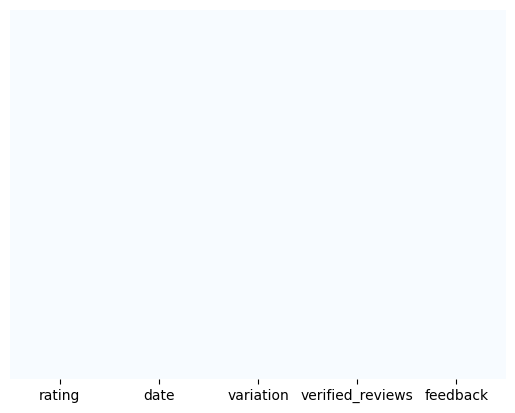

In [ ]:
# There are not any missing values
sns.heatmap(reviews_df.isnull(), yticklabels=False, cbar=False, cmap='Blues')

array([[<Axes: title={'center': 'rating'}>,
        <Axes: title={'center': 'feedback'}>]], dtype=object)

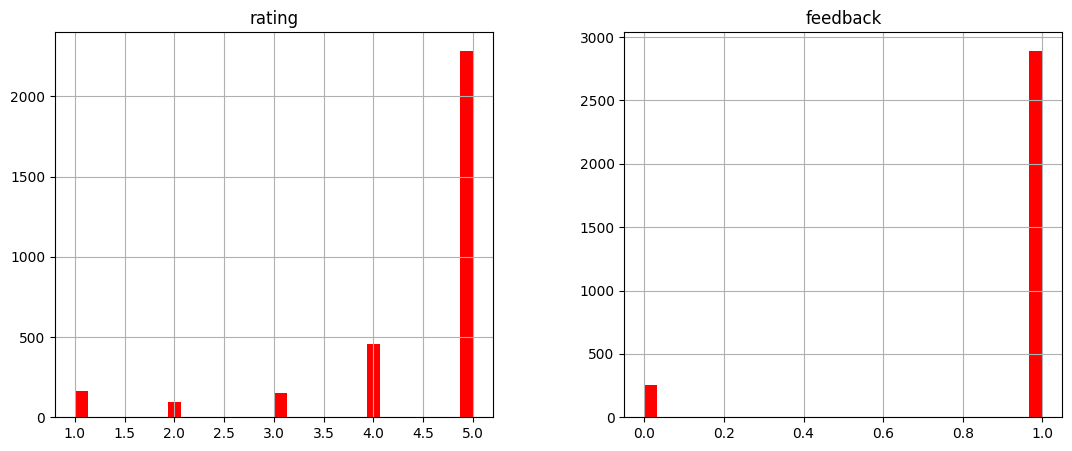

In [ ]:
reviews_df.hist(bins=30, figsize=(13,5), color='r')

Five and four stars majority means the product is fulfilling

*   Five stars reting are the largest
*   Four stars is the second
*   Feedback number 1 means positive feedback
*   Category feedback 0 is ver low




In [5]:
# The length column is created in order to check the review's length.
reviews_df['length'] = reviews_df['verified_reviews'].apply(len)
reviews_df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


New column 'length' for the total of characters in the 'verified_reviews' column

<Axes: ylabel='Frequency'>

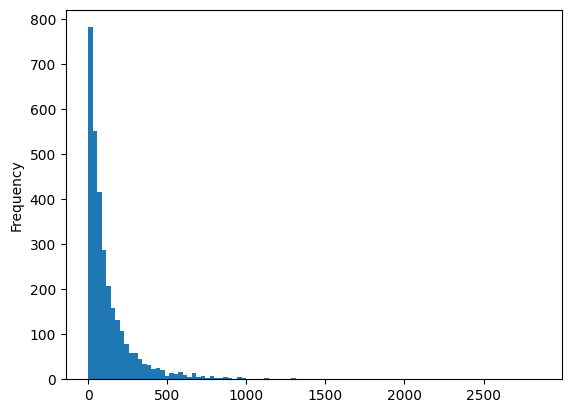

In [ ]:
reviews_df['length'].plot(bins=100, kind='hist')

Most reviews are short the more large the review the less people write large feedbacks

In [ ]:
reviews_df.length.describe()

count    3150.000000
mean      132.049524
std       182.099952
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

The largest review:

In [ ]:
reviews_df[reviews_df['length'] == 2851]['verified_reviews'].iloc[0]

"Incredible piece of technology.I have this right center of my living room on an island kitchen counter. The mic and speaker goes in every direction and the quality of the sound is quite good. I connected the Echo via Bluetooth to my Sony soundbar on my TV but find the Echo placement and 360 sound more appealing. It's no audiophile equipment but there is good range and decent bass. The sound is more than adequate for any indoor entertaining and loud enough to bother neighbors in my building. The knob on the top works great for adjusting volume. This is my first Echo device and I would imagine having to press volume buttons (on the Echo 2) a large inconvenience and not as precise. For that alone I would recommend this over the regular Echo (2nd generation).The piece looks quality and is quite sturdy with some weight on it. The rubber material on the bottom has a good grip on the granite counter-- my cat can even rub her scent on it without tipping it over.This order came with a free Phi

The shortest review:

In [ ]:
reviews_df[reviews_df['length'] == 1]['verified_reviews'].iloc[0]

'😍'

Average review:

In [ ]:
reviews_df[reviews_df['length'] == 132]['verified_reviews'].iloc[0]

'Nice. It works good.Some times is not easy to recognize your voice and you have to repeat several times, some time almost screaming.'

In [ ]:
# Group by the 'variation' column to get the sum of ratings.
data = reviews_df.groupby('variation')['rating'].sum()
data

variation
Black                           1105
Black  Dot                      2298
Black  Plus                     1180
Black  Show                     1190
Black  Spot                     1039
Charcoal Fabric                 2034
Configuration: Fire TV Stick    1607
Heather Gray Fabric              737
Oak Finish                        68
Sandstone Fabric                 392
Walnut Finish                     44
White                            377
White  Dot                       814
White  Plus                      340
White  Show                      364
White  Spot                      470
Name: rating, dtype: int64

In [ ]:
# Grouping variation and aggregate column percentage for rating divide data.
data_perc=reviews_df.groupby('variation').agg(percentage=(('rating'), lambda p:p.sum()/data.sum()*100)).round(2)

In [ ]:
data_perc

,percentage
variation,
Black,7.86
Black Dot,16.35
Black Plus,8.39
Black Show,8.46
Black Spot,7.39
Charcoal Fabric,14.47
Configuration: Fire TV Stick,11.43
Heather Gray Fabric,5.24
Oak Finish,0.48


Plotting the values from the "percentage" column over the total number of samples in the dataframe.

This graphic shows a horizontal bar plot with labeled percentages. The bars represent the values from the "percentage" column
in the "data_perc" DataFrame, with their corresponding index values displayed on the y-axis.
The plot includes a title, x-axis label, y-axis label, and text labels on each bar displaying the percentage value.

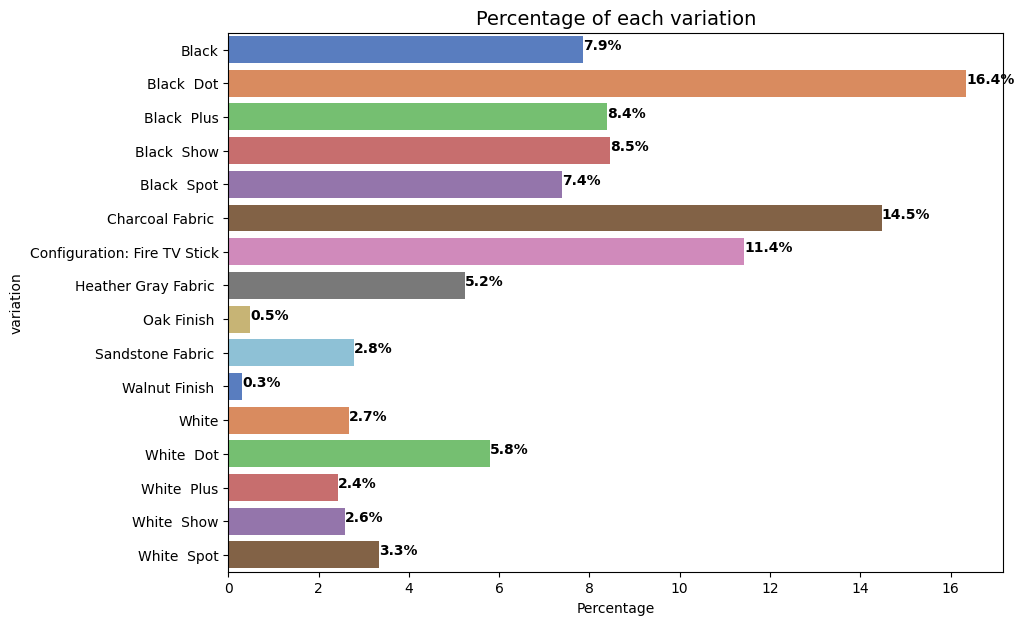

In [ ]:
bar,ax=plt.subplots(figsize=(10,7))
ax=sns.barplot(x='percentage',y=data_perc.index, data=data_perc, errorbar=None, palette="muted", orient='h') # y=data_perc.index specifies the index values of the `data_perc` DataFrame to be plotted on the y-axis.
ax.set_title("Percentage of each variation", fontsize=14)
ax.set_xlabel("Percentage")
ax.set_ylabel("variation")
for rect in ax.patches:
  ax.text(rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"%rect.get_width(), weight='bold')

In [ ]:
positive = reviews_df[reviews_df['feedback']==1]

In [ ]:
negative = reviews_df[reviews_df['feedback']==0]

In [ ]:
negative

,rating,date,variation,verified_reviews,feedback,length
46,2,30-Jul-18,Charcoal Fabric,"It's like Siri, in fact, Siri answers more acc...",0,163
111,2,30-Jul-18,Charcoal Fabric,Sound is terrible if u want good music too get...,0,53
141,1,30-Jul-18,Charcoal Fabric,Not much features.,0,18
162,1,30-Jul-18,Sandstone Fabric,"Stopped working after 2 weeks ,didn't follow c...",0,87
176,2,30-Jul-18,Heather Gray Fabric,Sad joke. Worthless.,0,20
...,...,...,...,...,...,...
3047,1,30-Jul-18,Black Dot,Echo Dot responds to us when we aren't even ta...,0,120
3048,1,30-Jul-18,White Dot,NOT CONNECTED TO MY PHONE PLAYLIST :(,0,37
3067,2,30-Jul-18,Black Dot,The only negative we have on this product is t...,0,240
3091,1,30-Jul-18,Black Dot,I didn’t order it,0,17


In [ ]:
positive

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1,50
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1,135
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1,441
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1,380


<Axes: xlabel='feedback', ylabel='count'>

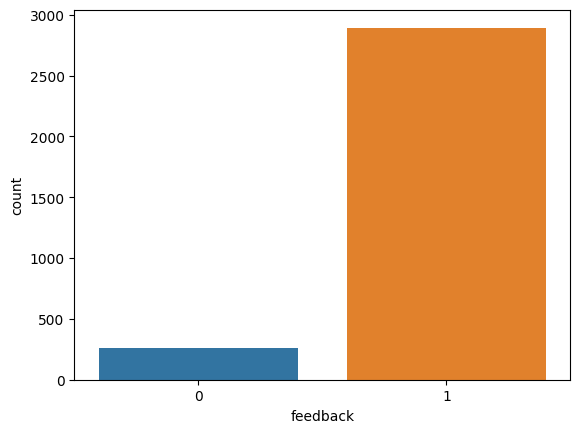

In [ ]:
# Disbalanced output
sns.countplot(x='feedback', data=reviews_df)

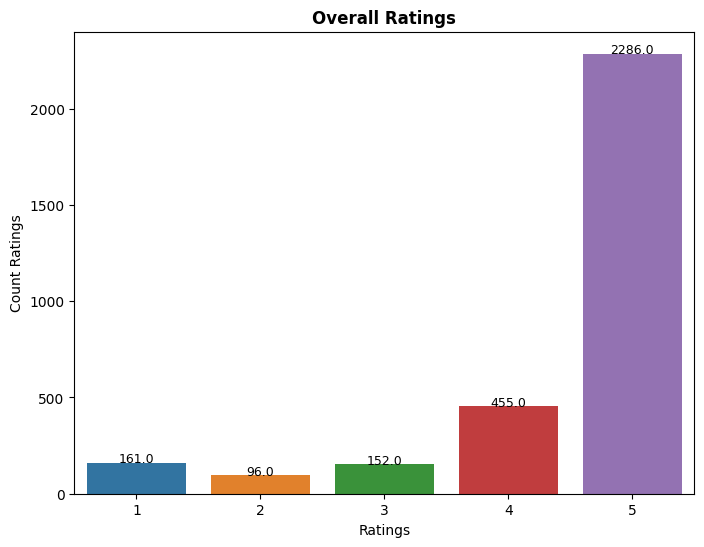

In [ ]:
# Five stars rating is the major rating with 2286 records.
countplt, ax = plt.subplots(figsize = (8,6))
ax =sns.countplot(x = 'rating', data=reviews_df)
ax.set_title('Overall Ratings', fontweight='bold')
ax.set_xlabel('Ratings')
ax.set_ylabel('Count Ratings')
for rect in ax.patches:
  ax.text(rect.get_x() + rect.get_width()  / 2, rect.get_height() + 0.75, rect.get_height(), horizontalalignment='center', fontsize=9)

<Axes: >

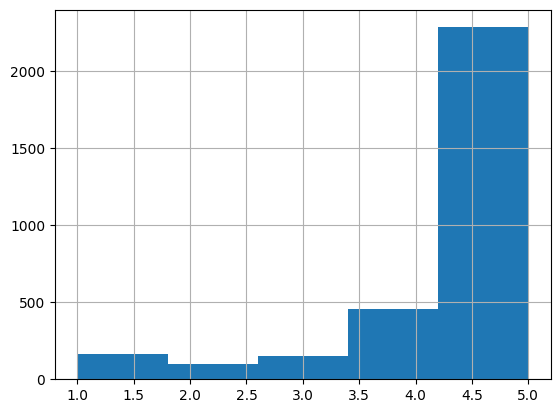

In [ ]:
# Histogram with frequency distributions
reviews_df['rating'].hist(bins=5)

<Axes: xlabel='variation', ylabel='rating'>

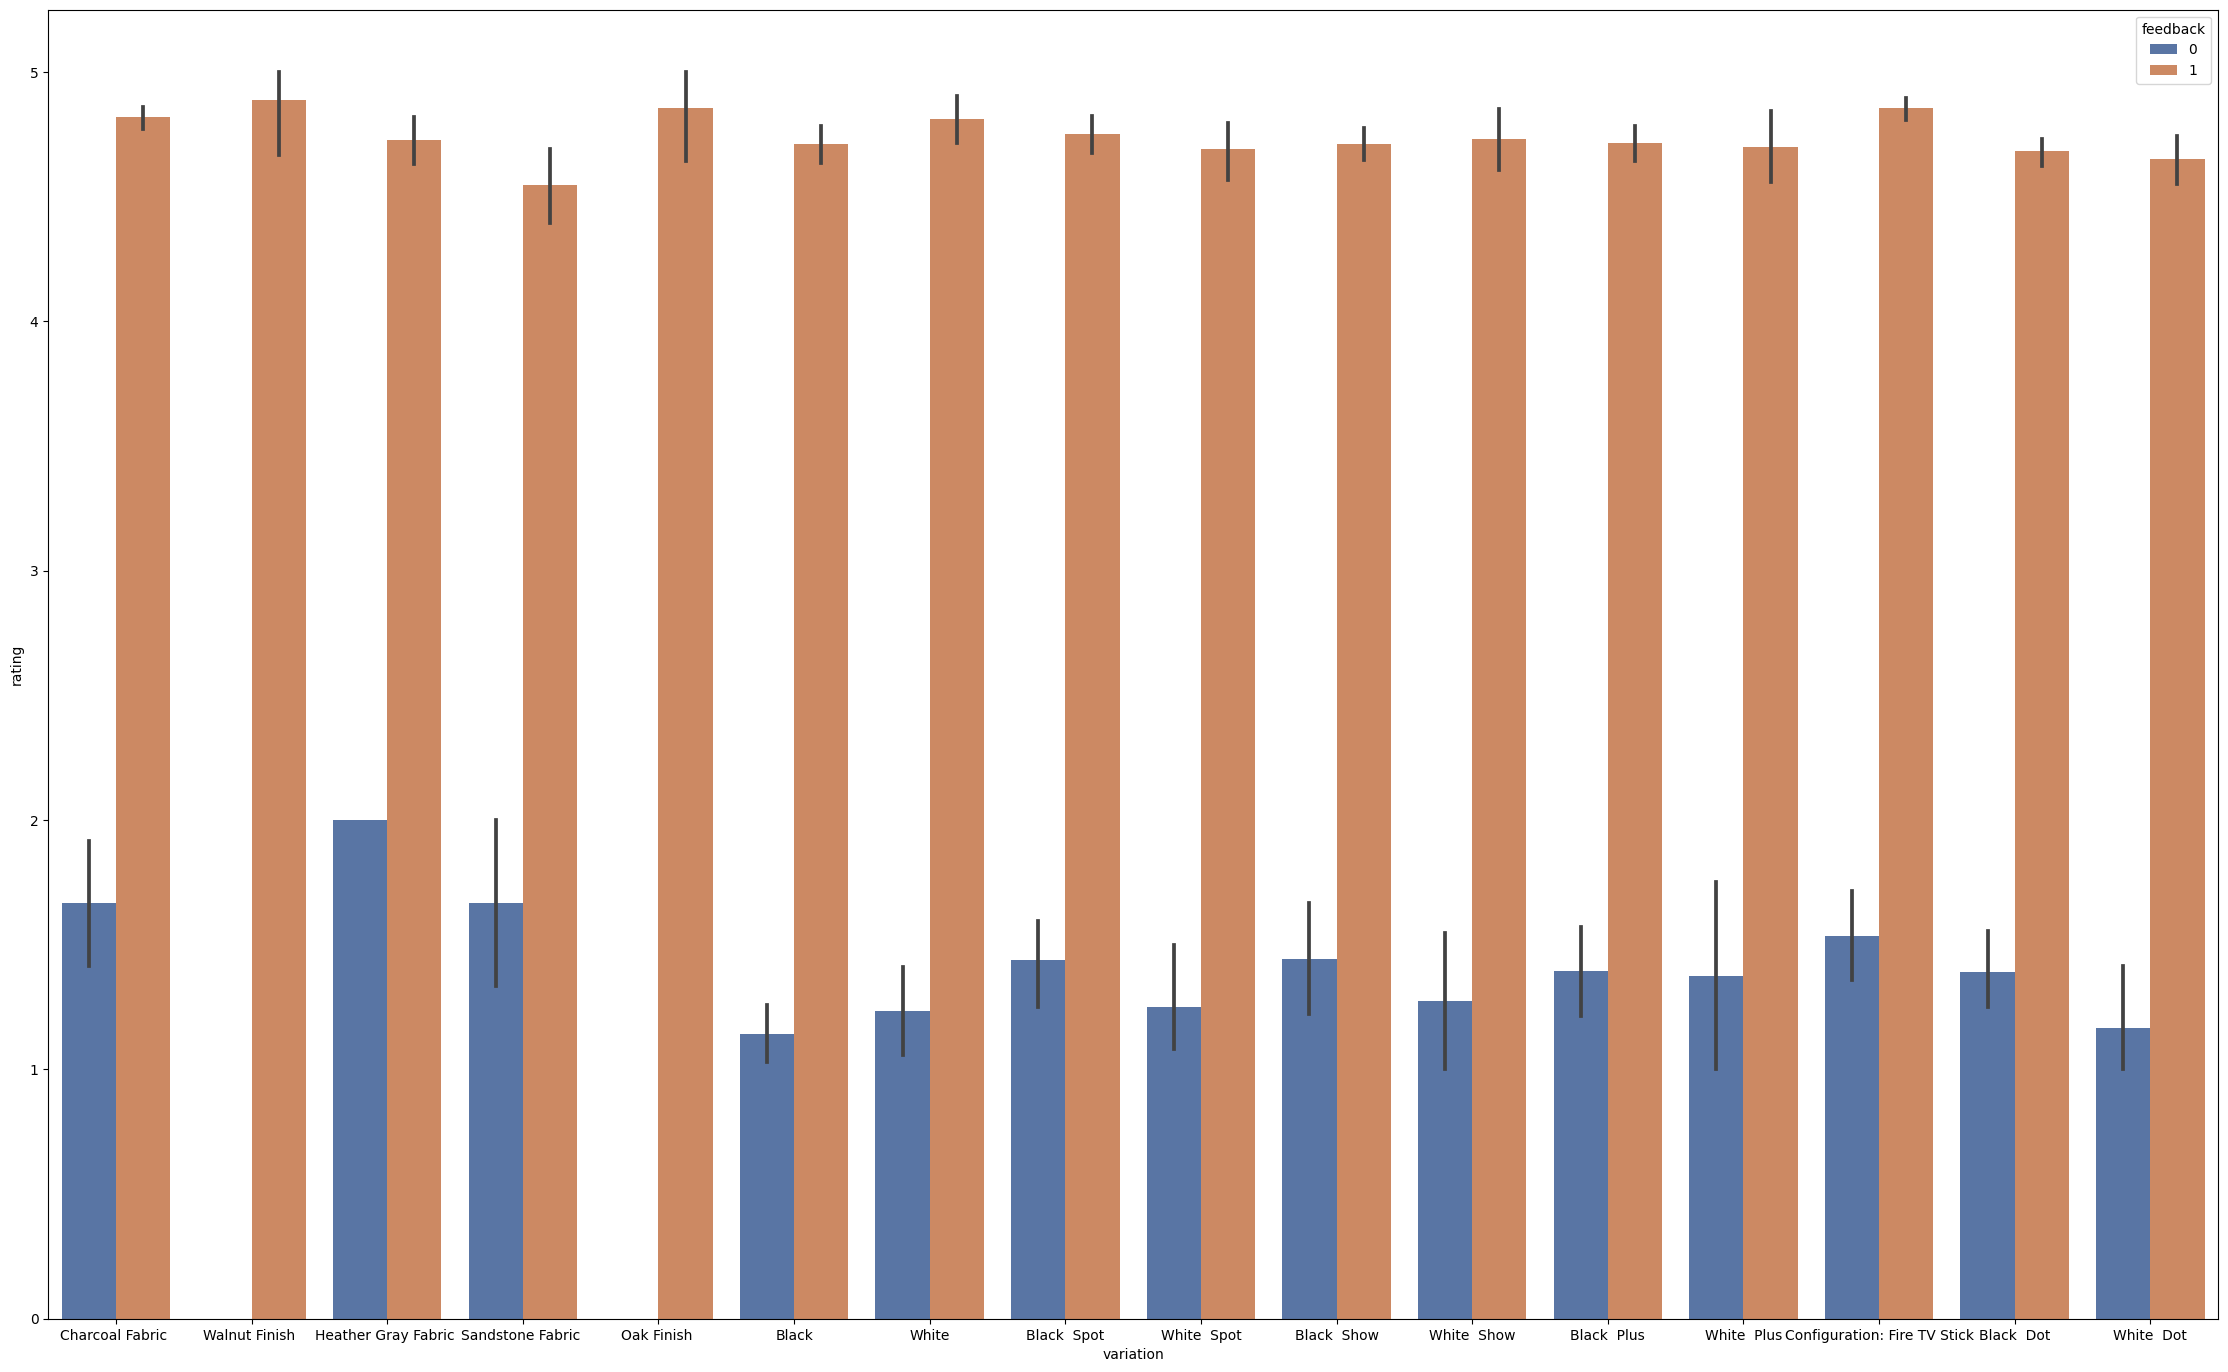

In [ ]:
# All variations receive mostly positive feedback.
plt.figure(figsize=(28,17))
sns.barplot(x='variation', y='rating', data=reviews_df, palette='deep', hue='feedback')

<Axes: xlabel='variation', ylabel='rating'>

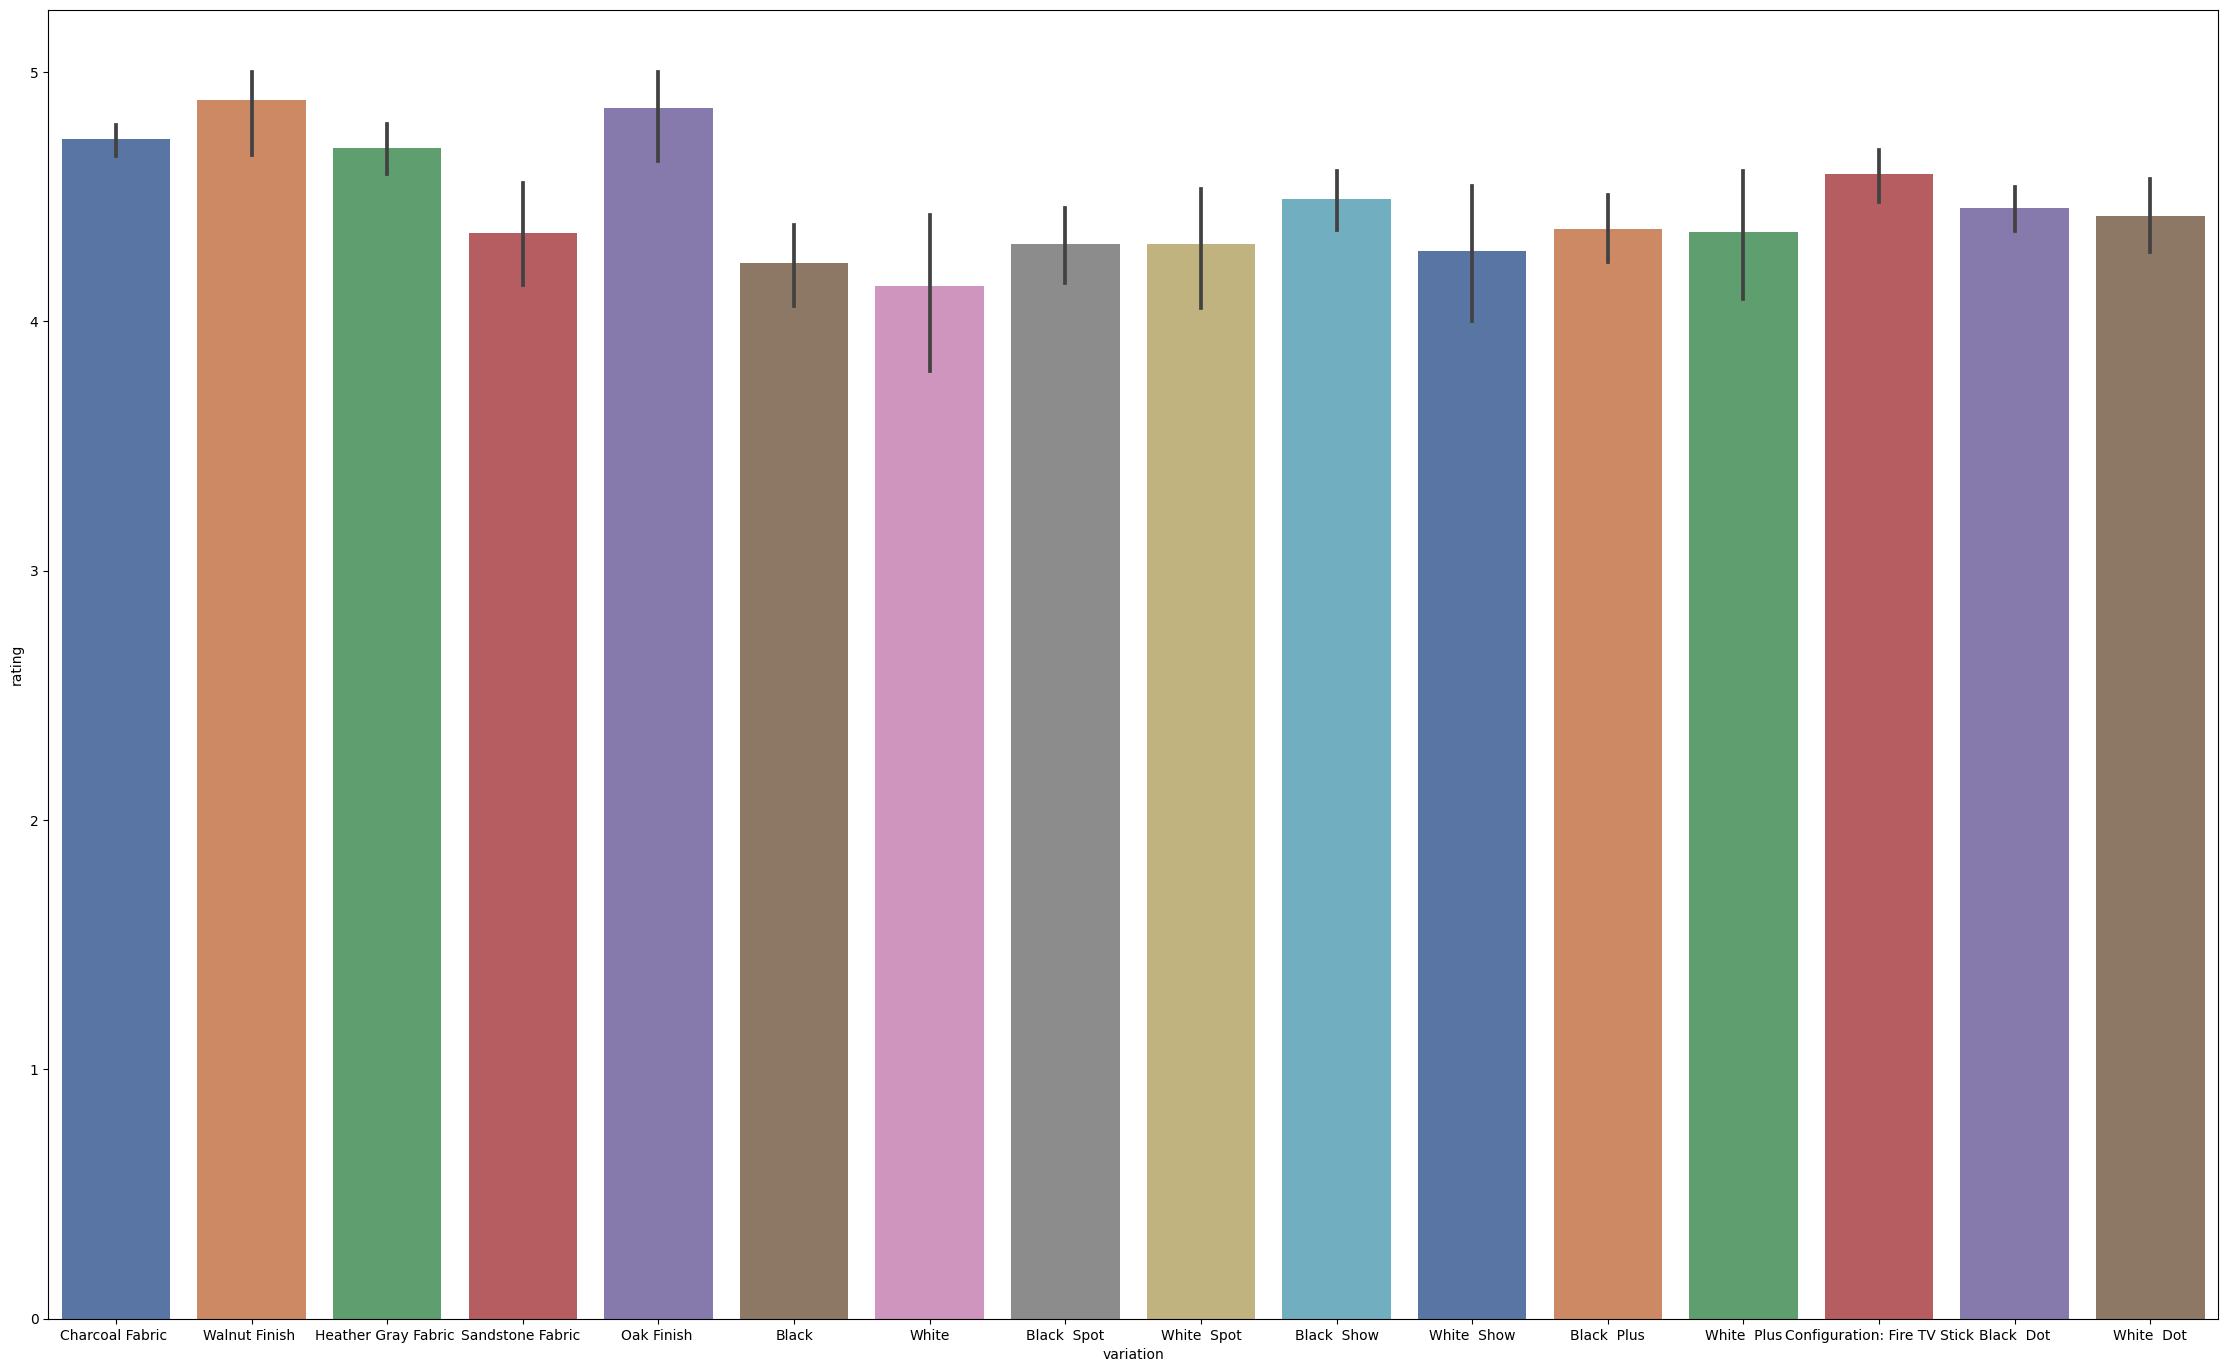

In [ ]:
# Countplot of each variation.
plt.figure(figsize=(28,17))
sns.barplot(x='variation', y='rating', data=reviews_df, palette='deep')

In [ ]:
reviews_df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [ ]:
sentences = reviews_df['verified_reviews'].tolist()
len(sentences) # 3150 reviews.

3150

In [ ]:
sentences_as_one_string= " ".join(sentences) # Getting all reviews in one big list.

In [ ]:
sentences_as_one_string

'Love my Echo! Loved it! Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home. I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well. Music I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do. Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.  She does not seem to be very smartbon politics yet. I think this is the 5th one I\'ve purchased. I\'m working on 

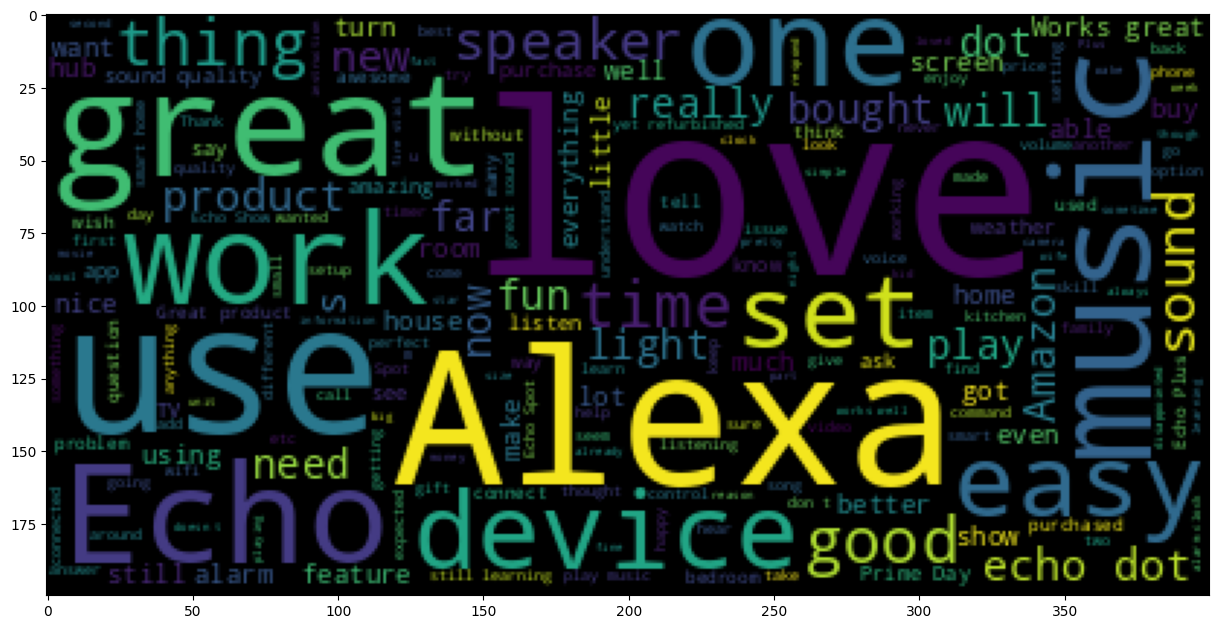

In [ ]:
# Wordcloud
plt.figure(figsize=(15,15))
plt.imshow(WordCloud().generate(sentences_as_one_string))
# The size of each word is proportional to the number of times it appears in the list created: 'great', 'use', 'love' and 'Alexa' are the largest.
# The dataset has positive majority

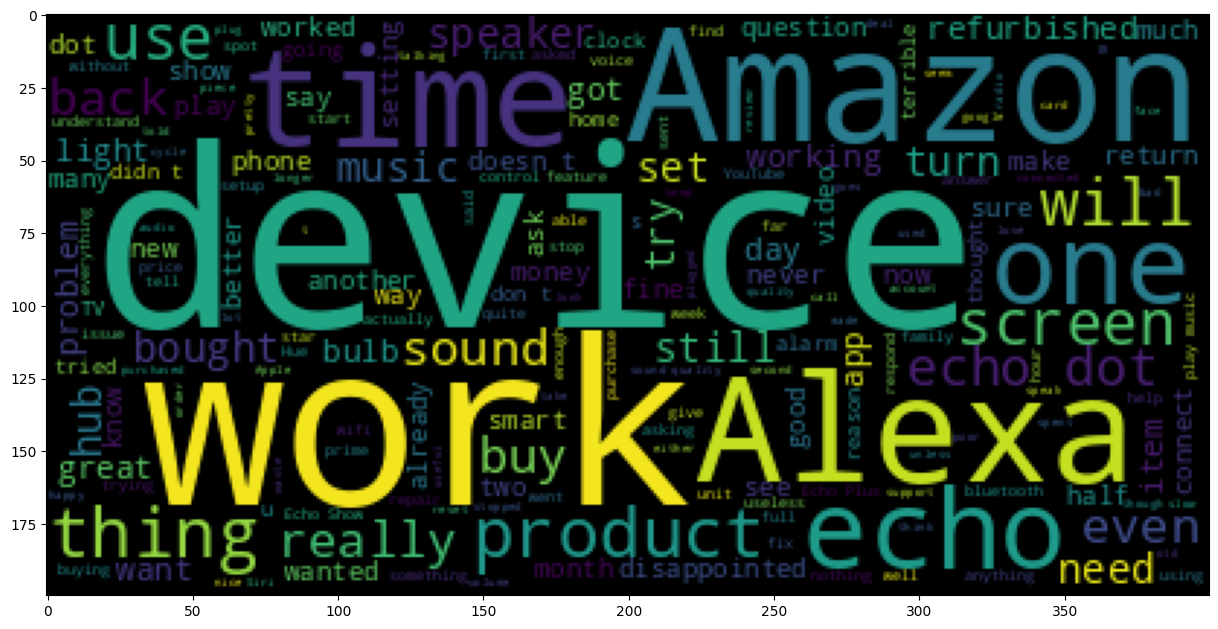

In [ ]:
negative_list = negative['verified_reviews'].tolist()
negative_as_one_string= " ".join(negative_list)
plt.figure(figsize=(15,15))
plt.imshow(WordCloud().generate(negative_as_one_string))
# Worcloud from negative reviews. Negative words in a negative context: 'disappointed', 'try', 'set', 'working', 'time', 'device'

# DATA CLEANING AND DUMMY VARIABLES

In [6]:
reviews_df = reviews_df.drop(['date', 'rating', 'length'], axis=1) # We don't need these columns.

In [ ]:
reviews_df.head()

,variation,verified_reviews,feedback
0,Charcoal Fabric,Love my Echo!,1
1,Charcoal Fabric,Loved it!,1
2,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,Charcoal Fabric,Music,1


In [7]:
# Turn into dummies variables the column variation.
variation_dummies = pd.get_dummies(reviews_df['variation'], drop_first=True)

In [ ]:
variation_dummies

,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3146,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3148,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [8]:
reviews_df.drop(['variation'], axis=1, inplace=True)

In [9]:
# Concatenate the original dataframe with the created dummy variables.
reviews_df = pd.concat([reviews_df, variation_dummies], axis=1)

In [ ]:
reviews_df

,verified_reviews,feedback,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,Love my Echo!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Loved it!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"Sometimes while playing a game, you can answer...",1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,I have had a lot of fun with this thing. My 4 ...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Music,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,"Perfect for kids, adults and everyone in betwe...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3146,"Listening to music, searching locations, check...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3147,"I do love these things, i have them running my...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3148,Only complaint I have is that the sound qualit...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


# REMOVE PUNCTUATION FROM TEXT

In [10]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
Test = "This is a notebook with Python code, it should be fine, Python rules !! AI rules !!..greetings for you"

In [ ]:
test_punc_removed = [char for char in Test if char not in string.punctuation] # Loop that removes string punctuation from Test.
test_punc_removed

In [13]:
# Sentence without string punctuations. Punctuation marks are eliminated as they are not needed.
test_punc_removed_join=''.join(test_punc_removed)
test_punc_removed_join

'This is a notebook with Python code it should be fine Python rules  AI rules greetings for you'

# STOPWORDS

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
from nltk.corpus import stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [11]:
test_punc_removed_join

'This is a notebook with Python code it should be fine Python rules  AI rules greetings for you'

In [16]:
# This removes the stopwords from the sentence without punctuation marks.
test_punc_removed_join_clean = [word for word in test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]

In [17]:
test_punc_removed_join_clean

['notebook',
 'Python',
 'code',
 'fine',
 'Python',
 'rules',
 'AI',
 'rules',
 'greetings']

# TOKENS FOR TEXT

In [18]:
sample_data = ['This is the first document.','This document is the second document.','And this is the third one.','Is this the first document?']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sample_data)

In [19]:
print(vectorizer.get_feature_names_out()) # Get output feature names for transformation.
# These are the words that appear in the text without repeating themselves, everything is in lower case.

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']


In [20]:
print(X.toarray()) # Tokens for each sentence.

[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


# DATA CLEANING

In [21]:
# We define a pipeline to clean up all messages.
# The pipeline performs the following: (1) remove punctuation marks, (2) remove stopwords.
def message_cleaning(message):
  Test_punc_removed = [char for char in message if char not in string.punctuation]
  Test_punc_removed_join = ''.join(Test_punc_removed)
  Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
  return Test_punc_removed_join_clean # Returns the final operation.

In [22]:
# Testing the function.
reviews_df_clean = reviews_df['verified_reviews'].apply(message_cleaning)

In [ ]:
print(reviews_df_clean[3])

['lot', 'fun', 'thing', '4', 'yr', 'old', 'learns', 'dinosaurs', 'control', 'lights', 'play', 'games', 'like', 'categories', 'nice', 'sound', 'playing', 'music', 'well']


In [ ]:
print(reviews_df['verified_reviews'][3])

I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.


In [ ]:
reviews_df_clean

0                                            [Love, Echo]
1                                                 [Loved]
2       [Sometimes, playing, game, answer, question, c...
3       [lot, fun, thing, 4, yr, old, learns, dinosaur...
4                                                 [Music]
                              ...                        
3145                    [Perfect, kids, adults, everyone]
3146    [Listening, music, searching, locations, check...
3147    [love, things, running, entire, home, TV, ligh...
3148    [complaint, sound, quality, isnt, great, mostl...
3149                                               [Good]
Name: verified_reviews, Length: 3150, dtype: object

In [23]:
# CountVectorizer transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.
vectorizer = CountVectorizer(analyzer=message_cleaning) # The message_cleaning function is the parameter.
reviews_countvectorizer = vectorizer.fit_transform(reviews_df['verified_reviews'])

In [ ]:
print(vectorizer.get_feature_names_out())

['072318' '1' '10' ... '😬' '😳' '🤓']


In [ ]:
# Array where in each row the phrase is shown and in each column the presence or absence of the word in question.
print(reviews_countvectorizer.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# 3150 rows, 5211 different words
reviews_countvectorizer.shape

(3150, 5211)

In [ ]:
reviews_df

,verified_reviews,feedback,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,Love my Echo!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Loved it!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"Sometimes while playing a game, you can answer...",1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,I have had a lot of fun with this thing. My 4 ...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Music,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,"Perfect for kids, adults and everyone in betwe...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3146,"Listening to music, searching locations, check...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3147,"I do love these things, i have them running my...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3148,Only complaint I have is that the sound qualit...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [24]:
# Drop column
reviews_df.drop(['verified_reviews'], axis = 1, inplace=True)

In [25]:
# The array of 0 and 1 of the reviews, i.e. the tokens of each phrase is converted to dataframe.
reviews = pd.DataFrame(reviews_countvectorizer.toarray())

In [26]:
# Concatenate the two dataframes.
reviews_df = pd.concat([reviews_df, reviews], axis=1)

In [27]:
# Feedback and categories remain in the dataframe
reviews_df

,feedback,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,...,5201,5202,5203,5204,5205,5206,5207,5208,5209,5210
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3146,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3147,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3148,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
X = reviews_df.drop(['feedback'], axis=1)
X

,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,...,5201,5202,5203,5204,5205,5206,5207,5208,5209,5210
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3146,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3147,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Target
y = reviews_df['feedback']
y

0       1
1       1
2       1
3       1
4       1
       ..
3145    1
3146    1
3147    1
3148    1
3149    1
Name: feedback, Length: 3150, dtype: int64

# NAIVE BAYES MODEL

In [ ]:
X.shape

(3150, 5226)

In [ ]:
y.shape

(3150,)

In [ ]:
X.dtypes

Black  Dot          uint8
Black  Plus         uint8
Black  Show         uint8
Black  Spot         uint8
Charcoal Fabric     uint8
                    ...  
5206                int64
5207                int64
5208                int64
5209                int64
5210                int64
Length: 5226, dtype: object

In [ ]:
# The dataframe's columns are converted to str otherwise the MultinomialNB is not executed.
X.columns = X.columns.astype(str)

In [ ]:
# Train test split 80 - 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Bayes’ Theorem

Bayes’ Theorem finds the probability of an event occurring given the probability of another event that has already occurred. This is the equation:
`P (A│B) = [P(B│A) P(A)] / P(B)`
where A and B are events and P(B) ≠ 0.




1.   Basically, we are trying to find probability of event A, given the event B is
true. Event B is also termed as evidence.
2.   P(A) is the priori of A (the prior probability, i.e. Probability of event before evidence is seen). The evidence is an attribute value of an unknown instance(here, it is event B).
3.   P(A|B) is a posteriori probability of B, i.e. probability of event after evidence is seen.

Taken to our model we apply Baye's Theorem in this way `P(y|X) = P(X|y)P(y) / P(X)`, where y is the class variable and X is a dependent feature vector (of size n) where `X = (X1,X2,X3,.....,Xn)`

In [ ]:
# Naive Bayes classifier for multinomial models from sklearn
nb_multinomial = MultinomialNB()
nb_multinomial.fit(X_train, y_train)

MultinomialNB()

Text(0.5, 1.0, 'Confusion Matrix NB Model - Train set')

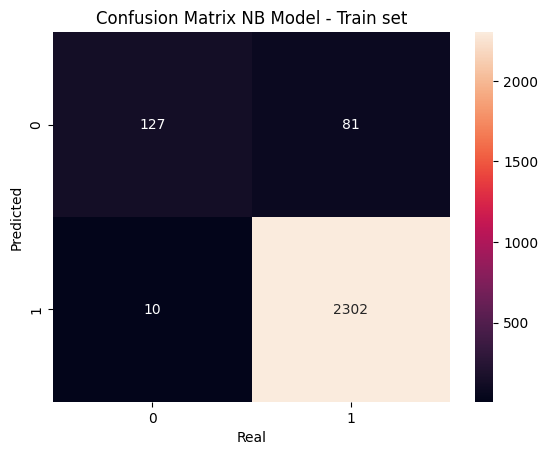

In [ ]:
y_predict_train = nb_multinomial.predict(X_train) # Prediction of the model with the training set.
y_predict_train
# Heatmap - train set
ax = plt.subplot()
cm = confusion_matrix(y_train, y_predict_train)
sns.heatmap(cm, annot=True, ax=ax, fmt='d')
# Labels
ax.set_xlabel('Real');ax.set_ylabel('Predicted');
ax.set_title('Confusion Matrix NB Model - Train set')

In [ ]:
# Training set Classification report
report_train = classification_report(y_train, y_predict_train, target_names=['Negative','Positive'])
print(report_train)

              precision    recall  f1-score   support

    Negative       0.93      0.61      0.74       208
    Positive       0.97      1.00      0.98      2312

    accuracy                           0.96      2520
   macro avg       0.95      0.80      0.86      2520
weighted avg       0.96      0.96      0.96      2520



As expected, the model predicted positive reviews well since it is the majority class of the dataset.


*   Precisión: Out of all the positive predicted, what percentage is truly positive. The positive class has a high accuracy along with the negative reviews since the rate of true positives is high.
*   Recall: Out of the total positive, what percentage are predicted positive, the positive class is in the majority while the negative class, being the minority class, has a low recall.
*   f1-score: Is the harmonic or balanced mean of the model performance, despite the class imbalance, the negative class has a high f1-score value.

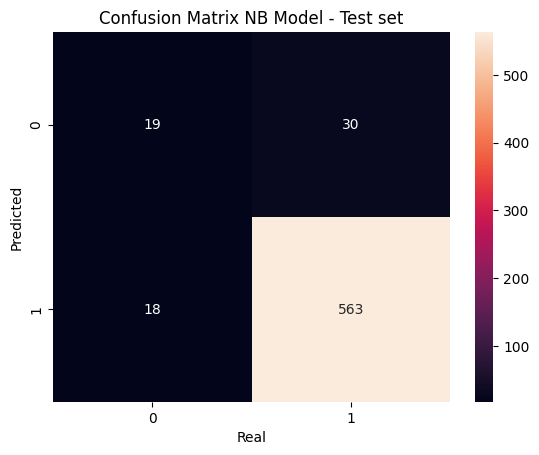

In [ ]:
# Heatmap - test set
y_predict_test = nb_multinomial.predict(X_test)
ax = plt.subplot()
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot = True, ax=ax, fmt='d')
# Labels
ax.set_xlabel('Real');ax.set_ylabel('Predicted');
ax.set_title('Confusion Matrix NB Model - Test set');
# Columnas: real, rows: predicted

In [ ]:
# Testing set Classification report
report_test = classification_report(y_test, y_predict_test,target_names=['Negative','Positive'])
print(report_test)

              precision    recall  f1-score   support

    Negative       0.51      0.39      0.44        49
    Positive       0.95      0.97      0.96       581

    accuracy                           0.92       630
   macro avg       0.73      0.68      0.70       630
weighted avg       0.92      0.92      0.92       630



En el test set set el modelo tiene un rendimiento similar al training set.


*   The recall rate of the negative class is low due to the imbalance in the test, there are fewer elements for which the negatives were not correctly predicted.
*   High precision and recall in the positive class the model correctly predicts this class.
*   The f1-score rate in the negative class was very low as it had a lot of false negatives.
*   The negative class (0) had 30 false negatives out of 49, which is high for such a small sample.


# SMOTE

We can treat the unbalance with oversampling techniques in order to balance classes.

**SMOTE**: SMOTE viene de  Synthetic Minority Oversampling TEchnique, esta técnica hace an over-sampling approach in which the minority class is over-sampled by creating “synthetic” examples rather than by over-sampling with replacement. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))


Before OverSampling, counts of label '1': 2312
Before OverSampling, counts of label '0': 208 

After OverSampling, the shape of train_X: (4624, 5226)
After OverSampling, the shape of train_y: (4624,) 

After OverSampling, counts of label '1': 2312
After OverSampling, counts of label '0': 2312


The positive class is the majority, before oversampling it has a percentage of 92% of the total training set, once SMOTE is executed the synthetic samples are created balancing positives and negatives at 2319 each.

In [ ]:
# Naive Bayes model using SMOTE
nb_multinomial_sm = MultinomialNB()
nb_multinomial_sm.fit(X_train_res, y_train_res)

MultinomialNB()

Text(0.5, 1.0, 'Confusion Matrix Smote NB Model - Train set')

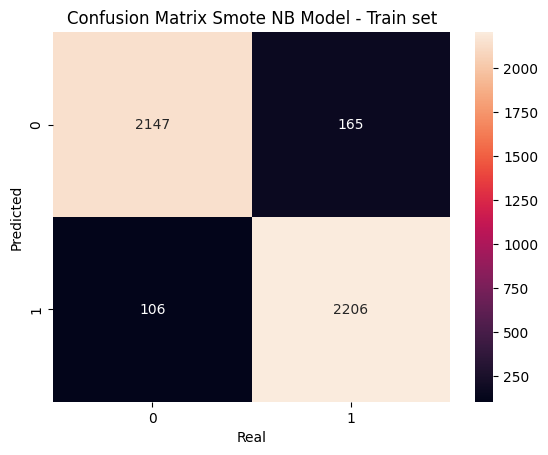

In [ ]:
# SMOTE train set
y_predict_train = nb_multinomial_sm.predict(X_train_res) # Predicción del modelo con el conjunto de training
y_predict_train # Esto es lo que hace el modelo dado una reviews el modelo indica si es positiva o negativa
# Heatmap del conjunto training
ax = plt.subplot()
cm = confusion_matrix(y_train_res, y_predict_train) # y_train son los datos verdaderos, y_predict_train es la predicción
sns.heatmap(cm, annot=True, ax=ax, fmt='d')
# Etiquetas, titulo e info
ax.set_xlabel('Real');ax.set_ylabel('Predicted');
ax.set_title('Confusion Matrix Smote NB Model - Train set')

In [ ]:
# Smote Training set Classification report
report_train = classification_report(y_train_res, y_predict_train, target_names=['Negative','Positive'])
print(report_train)

              precision    recall  f1-score   support

    Negative       0.95      0.93      0.94      2312
    Positive       0.93      0.95      0.94      2312

    accuracy                           0.94      4624
   macro avg       0.94      0.94      0.94      4624
weighted avg       0.94      0.94      0.94      4624



With the synthetic SMOTE samples, the negative class, which had a very low recall due to the imbalance, is improved, and with the balanced classes the recall rates are similar, since false negatives are reduced.

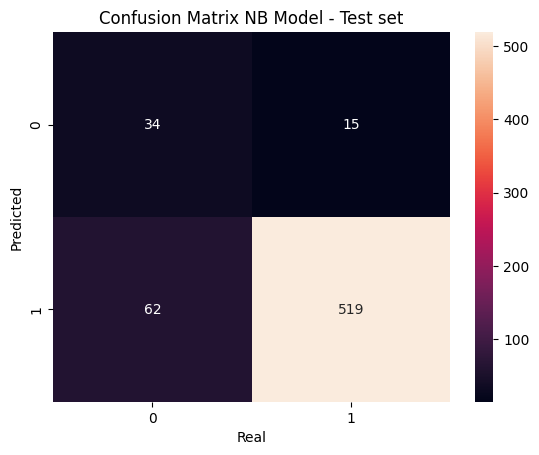

In [ ]:
# Smote test set
y_predict_test = nb_multinomial_sm.predict(X_test)
ax = plt.subplot()
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot = True, ax=ax, fmt='d')
# Etiquetas, titulo e info
ax.set_xlabel('Real');ax.set_ylabel('Predicted');
ax.set_title('Confusion Matrix NB Model - Test set');
# Columnas real, filas predicho

In [ ]:
# Smote Testing set Classification report
report_test = classification_report(y_test, y_predict_test,target_names=['Negative','Positive'])
print(report_test)

              precision    recall  f1-score   support

    Negative       0.35      0.69      0.47        49
    Positive       0.97      0.89      0.93       581

    accuracy                           0.88       630
   macro avg       0.66      0.79      0.70       630
weighted avg       0.92      0.88      0.90       630



SMOTE is only applied to the training set, the synthetic samples are created in the training set and evaluated in the original test set without oversampling with this the model will have a better idea of the boundary and perform better.
The false negatives of the negative class were reduced, the recall was improved as well as the f1-score.

## Logistic Regression Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)


pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000)]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print("Cross-validation score percentage: %.3f%% \nTest score percentage: %.3f%%" % (cv_score.mean()*100.0, test_score.mean()*100.0))

Cross-validation score: 0.8001109514506418
Test score: 0.8262216803819974
Cross-validation score percentage: 80.011% 
Test score percentage: 82.622%


In the above code a Logistic Regression model is run with the use of SMOTE, pipeline and Cross-validation. Some important parameters are:


*   Stratify: performs a division so that the proportion of values in the sample produced is the same as the proportion of values provided to the stratify parameter. This helps to preserve the class distribution.
*   imbpipeline: is used as part of the class imblearn.pipeline.
*   StratifiedKFold: This cross-validation object is a variation of KFold that returns stratified flods. The folds are performed preserving the percentage of samples for each class. Special for unbalanced datasets and classification problems.
*   scoring: se utliza roc_auc para problemas de clasificación binaria, este método es óptimo para datasets desbalanceados.
*   grid_search: The code fits the grid search object (grid_search) on the training data (X_train and y_train). It performs an exhaustive search over the hyperparameter grid to find the best combination of hyperparameters that maximizes the AUC-ROC score during cross-validation

This code demonstrates how to handle imbalanced data using SMOTE and logistic regression and perform hyperparameter tuning using Grid Search Cross-Validation to find the best model for classification tasks. It evaluates the model's performance using AUC-ROC as the evaluation metric and prints the cross-validation score and test score

In [ ]:
# Generate test set confusion matrix, logistic regression model
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[ 18  33]
 [  6 573]]


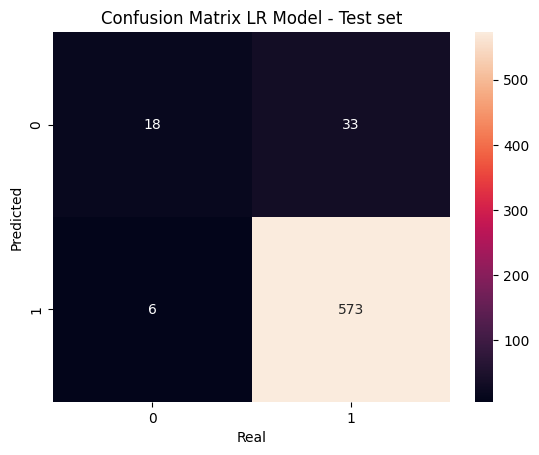

In [ ]:
# Heatmap test set LR model
ax = sns.heatmap(cf_matrix, annot=True, fmt='d')
ax.set_title('Confusion Matrix LR Model - Test set');
ax.set_xlabel('Real')
ax.set_ylabel('Predicted');
plt.show()

In [ ]:
# Testing set Classification report
report_test = classification_report(y_test, y_pred,target_names=['Negative','Positive'])
print(report_test)

              precision    recall  f1-score   support

    Negative       0.75      0.35      0.48        51
    Positive       0.95      0.99      0.97       579

    accuracy                           0.94       630
   macro avg       0.85      0.67      0.72       630
weighted avg       0.93      0.94      0.93       630



We got a good accuracy 80.011% and a 82.622% using cross-validation, this accuracy is the number of correct predictions as a percentage of all predictions made. It is good number since there is no overfitting and the numbers are similar, in general the SMOTE technique helps to improve the model in some aspects since the recall in test is improved while the recall of the positive class remains high. Precision for both classes are high given the inbalance with the negative class.